## 001 MLE/MAP Estimates

Date: 19.Jul.2022

### Purpose

Explore maximum likelihood and maximum a posteriori parameter fitting for craving slots task.

### Outline of Plan

1. Implement MLE using scipy.optimize.minimize
2. Implement MAP by extending previous model using loglik of gaussian prior

### What we did in this notebook

1. Reused the data loading functions written previously
2. Wrote non-gradient and gradient specified versions of RW models
3. Tested performance of NG and G RW models (NG is faster)
4. Implemented RW, RWDecay, RWFictive, Biased, Heuristic models
5. Implemented MAP version of models
6. Wrote a BIC comparison function to display results (similar to Q Huys emfit)


In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.special import logsumexp, expit, logit
from scipy.stats import norm, multivariate_normal
from sys import path
import numdifftools as nd

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data, plotting # type: ignore

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [56]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Standard MLE with minimize

In [18]:
sub_df = longform[(longform['PID'] == '61281debe85082cc937dd9ae')&(longform['Type'] == 'money')]
sub_df['Action'].values

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
def llrw(params, *args):
    """
    Log-likelihood function for the RW model.
    """
    alpha, beta = params
    alpha = expit(alpha)
    beta = np.exp(beta)
    actions, rewards = args
    Qs = np.zeros(2)+ 0.5
    loglik = 0
    for a, r in zip(actions, rewards):
        q0 = beta*Qs - logsumexp(beta*Qs)
        loglik += q0[a]

        Qs[a] = Qs[a] + alpha*(r - Qs[a])
        
    return -loglik

In [114]:
%timeit minimize(llrw, [0, 0], args=(sub_df['Action'].values, sub_df['Reward'].values))

77.5 ms ± 9.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## MLE with minimize + gradients

In [46]:
sub_df = longform[(longform['PID'] == '61281debe85082cc937dd9ae')&(longform['Type'] == 'money')]
sub_df['Action'].values

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
p = np.array([1, 2])
x = np.zeros(2)+0.5
np.dot(p, x)

1.5

In [208]:
def llrwgrad(params, *args):
    """
    Log-likelihood function for the RW model.
    """
    alpha, beta = params
    if beta > 5:
        return np.inf, np.array([np.inf, np.inf])

    alpha = 1/(1+np.exp(-alpha))
    beta = np.exp(beta)
    actions, rewards = args
    Qs = np.zeros(2)+ 0.5
    dqda = np.zeros(2)

    loglik = 0
    dl = np.zeros(len(params))
    for a, r in zip(actions, rewards):
        # a = int(sub_df['Action'].values[t])
        # r = sub_df['Reward'].values[t]
        q0 = beta*Qs
        l0 = q0 - np.max(q0)
        l0 = l0 - logsumexp(l0)
        p = np.exp(l0)
        loglik += l0[a]
        dl[1] = dl[1] + Qs[a] - np.dot(p, Qs)
        dl[0] = dl[0]+ beta*dqda[a] - np.dot(p, beta*dqda)
        dqda[a] = (1-alpha)*dqda[a] + r - Qs[a]

        Qs[a] = Qs[a] + alpha*(r - Qs[a])
        
    return -loglik, -dl

In [210]:
minimize(llrwgrad, [0, 0], args=(sub_df['Action'].values, sub_df['Reward'].values), method='L-BFGS-B', jac=True)

      fun: 12.469233053748091
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.24157206e+01,  6.14039742e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 47
      nit: 13
     njev: 47
   status: 0
  success: True
        x: array([3.67349285, 3.73969354])

## Gradient fitting

In [ ]:
def llrwgrad(params, *args):
    """
    Log-likelihood function for the RW model.
    """
    alpha, beta = params
    if beta > 5:
        return np.inf, np.array([np.inf, np.inf])

    alpha = 1/(1+np.exp(-alpha))
    beta = np.exp(beta)
    actions, rewards = args
    Qs = np.zeros(2)+ 0.5
    dqda = np.zeros(2)

    loglik = 0
    dl = np.zeros(len(params))
    for a, r in zip(actions, rewards):
        # a = int(sub_df['Action'].values[t])
        # r = sub_df['Reward'].values[t]
        q0 = beta*Qs
        l0 = q0 - np.max(q0)
        l0 = l0 - logsumexp(l0)
        p = np.exp(l0)
        loglik += l0[a]
        dl[1] = dl[1] + Qs[a] - np.dot(p, Qs)
        dl[0] = dl[0]+ beta*dqda[a] - np.dot(p, beta*dqda)
        dqda[a] = (1-alpha)*dqda[a] + r - Qs[a]

        Qs[a] = Qs[a] + alpha*(r - Qs[a])
        
    return -loglik, -dl

In [ ]:
def mlefitgrad(func, npar, longform):
    nsub = longform['PID'].unique().shape[0]
    param_est = np.zeros((2, npar, nsub))
    bics = np.zeros((2, nsub))
    for s, pid in enumerate(longform['PID'].unique()):
        for b, block in enumerate(['money', 'other']):
            sub_df = longform[(longform['PID'] == pid)&(longform['Type'] == block)]
            minstr = f'minimize({func}, [0, 0], args=(sub_df["Action"].values, sub_df["Reward"].values), method="L-BFGS-B", jac=True)'
            res = eval(minstr)
            bics[b, s] = 2*res.fun + npar*np.log(sub_df.shape[0])
            for i, est in enumerate(res.x):
                param_est[b, i, s] = est
    return param_est, bics

In [ ]:
%%time
param_est, bics = mlefitgrad('llrwgrad', 2, longform)

CPU times: user 14.1 s, sys: 108 ms, total: 14.2 s
Wall time: 14.5 s


## Non-gradient fitting (MAP)
Note that the prior is a multivariate Gaussian centered at 0^npar with cov = eye(npar)

In [228]:
class RW:
    def __init__(self):
        self.name = 'Rescorla-Wagner'
        self.short_name = 'rw'
        self.npars = 2
        self.parnames = ['alpha', 'beta']
        self.partransform = ['expit', 'np.exp']
        self.param_est = None
        self.bics = None
        self.ll = None

    def llfunc(self, params, *args):
        """
        Log-likelihood function for the RW model.
        """
        alpha, beta = params
        loglik = multivariate_normal.logpdf([alpha, beta], np.zeros(self.npars), 5*np.eye(self.npars))
        alpha = expit(alpha)
        beta = np.exp(beta)
        actions, rewards = args
        Qs = np.zeros(2)+ 0.5
        for a, r in zip(actions, rewards):
            q0 = beta*Qs - logsumexp(beta*Qs)
            loglik += q0[a]

            Qs[a] = Qs[a] + alpha*(r - Qs[a])
            
        return -loglik

In [229]:
class Heu:
    def __init__(self):
        self.name = 'Heuristic'
        self.short_name = 'heu'
        self.npars = 1
        self.parnames = ['eps']
        self.partransform = ['expit']
        self.param_est = None
        self.bics = None
        self.ll = None

    def llfunc(self, params, *args):
        """
        Log-likelihood function for the heuristic model.
        """
        eps = params
        loglik = multivariate_normal.logpdf(eps, 0, 1)
        eps = expit(eps)
        actions, rewards = args
        prev_reward = np.nan
        prev_action = np.nan
        for i, (a, r) in enumerate(zip(actions, rewards)):
            if i <=1:
                loglik += np.log(0.5)
            else:
                if r == 0 and prev_reward == 0:
                    if a == prev_action:
                        loglik += np.log(eps)
                    else:
                        loglik += np.log(1-eps)
                else:
                    if a == prev_action:
                        loglik += np.log(1-eps)
                    else:
                        loglik += np.log(eps)
            prev_reward = r
            prev_action = a
            
        return -loglik    

In [230]:
class Biased:
    def __init__(self):
        self.name = 'Biased'
        self.short_name = 'biased'
        self.npars = 1
        self.parnames = ['bias']
        self.partransform = ['expit']
        self.param_est = None
        self.bics = None
        self.ll = None

    def llfunc(self, params, *args):
        """
        Log-likelihood function for the Bias model.
        """
        bias = params
        loglik = multivariate_normal.pdf(bias, 0, 5)
        bias = expit(bias) # bias for left machine (#0)
        actions, rewards = args
        loglik = 0
        for a in actions:
            if a == 0:
                loglik += np.log(bias)
            else:
                loglik += np.log(1-bias)        
        return -loglik
    

In [231]:
class RWDecay:
    def __init__(self):
        self.name = 'Rescorla-Wagner with Decay'
        self.short_name = 'rwdecay'
        self.npars = 3
        self.parnames = ['alpha', 'beta', 'decay']
        self.partransform = ['expit', 'np.exp', 'expit']
        self.param_est = None
        self.bics = None
        self.ll = None

    def llfunc(self, params, *args):
        """
        Log-likelihood function for the RW model.
        """
        alpha, beta, decay = params
        loglik = multivariate_normal.logpdf([alpha, beta, decay], np.zeros(self.npars), 5*np.eye(self.npars))
        alpha = expit(alpha)
        beta = np.exp(beta)
        decay = expit(decay)
        actions, rewards = args
        Qs = np.zeros(2)+ 0.5
        for a, r in zip(actions, rewards):
            q0 = beta*Qs - logsumexp(beta*Qs)
            loglik += q0[a]

            Qs[a] = Qs[a] + alpha*(r - Qs[a])
            Qs[1-a] = Qs[1-a] + decay*(0.5 - Qs[1-a])
            
        return -loglik

In [232]:
class RWFictive:
    def __init__(self):
        self.name = 'Rescorla-Wagner with Fictive Update'
        self.short_name = 'rwfictive'
        self.npars = 3
        self.parnames = ['alpha', 'beta', 'fictive_alpha']
        self.partransform = ['expit', 'np.exp', 'expit']
        self.param_est = None
        self.bics = None
        self.ll = None

    def llfunc(self, params, *args):
        """
        Log-likelihood function for the RW model.
        """
        alpha, beta, fictive_alpha = params
        loglik = multivariate_normal.logpdf([alpha, beta, fictive_alpha], np.zeros(self.npars), 5*np.eye(self.npars))
        alpha = expit(alpha)
        beta = np.exp(beta)
        fictive_alpha = expit(fictive_alpha)
        actions, rewards = args
        Qs = np.zeros(2)+ 0.5
        for a, r in zip(actions, rewards):
            q0 = beta*Qs - logsumexp(beta*Qs)
            loglik += q0[a]

            Qs[a] = Qs[a] + alpha*(r - Qs[a])
            Qs[1-a] = Qs[1-a] - fictive_alpha*(r - Qs[a])
            
        return -loglik

In [233]:
def mlefit(model, longform):
    nsub = longform['PID'].unique().shape[0]
    bics = np.zeros((2, nsub))
    ll = np.zeros((2, nsub))
    model_obj = eval(f'{model}()')
    param_est = np.zeros((2, model_obj.npars, nsub))
    for s, pid in enumerate(longform['PID'].unique()):
        for b, block in enumerate(['money', 'other']):
            sub_df = longform[(longform['PID'] == pid)&(longform['Type'] == block)]
            minstr = f'minimize(model_obj.llfunc, np.zeros({model_obj.npars}), args=(sub_df["Action"].values, sub_df["Reward"].values))'
            res = eval(minstr)
            ll[b, s] = res.fun
            bics[b, s] = 2*res.fun + model_obj.npars*np.log(sub_df.shape[0])
            for i, est in enumerate(res.x):
                param_est[b, i, s] = est
    model_obj.param_est = param_est
    model_obj.bics = bics
    model_obj.ll = -ll
    money_table = pd.DataFrame({
        'Type': ['Money']*len(model_obj.param_est[0,0,:])
    })
    for i, param in enumerate(model_obj.parnames):
        money_table[param] = eval(f'{model_obj.partransform[i]}(model_obj.param_est[0, i, :])')
    money_table['BIC'] = model_obj.bics[0,:]
    money_table['LL'] = model_obj.ll[0,:]
    other_table = pd.DataFrame({
        'Type': ['Other']*len(model_obj.param_est[1,0,:])
    })
    for i, param in enumerate(model_obj.parnames):
        other_table[param] = eval(f'{model_obj.partransform[i]}(model_obj.param_est[1, i, :])')
    other_table['BIC'] = model_obj.bics[1,:]
    other_table['LL'] = model_obj.ll[1,:]
    model_obj.table = pd.concat([money_table, other_table])
    
    return model_obj

In [234]:
def batchfit(model_names):
    objs = []
    for name in model_names:
        print(f'Fitting {name}')
        objs.append(mlefit(name, longform))
    return objs

In [236]:
%%time
batch = batchfit(['Biased', 'Heu', 'RW', 'RWDecay', 'RWFictive'])

Fitting Biased
Fitting Heu
Fitting RW
Fitting RWDecay
Fitting RWFictive
CPU times: user 31.5 s, sys: 338 ms, total: 31.8 s
Wall time: 32.4 s


In [241]:
def model_comparison(model_list):
    full_money = pd.DataFrame()
    full_other = pd.DataFrame()
    for model in model_list:
        model_name = model.short_name
        model_table = model.table
        model_df = pd.DataFrame({
            'Model': [model_name],
            'Type': ['Money'],
            'BIC': [model_table[model_table['Type']=='Money']['BIC'].values.sum()]
        })
        full_money = pd.concat([full_money, model_df], ignore_index=True)
        model_df = pd.DataFrame({
            'Model': [model_name],
            'Type': ['Other'],
            'BIC': [model_table[model_table['Type']=='Other']['BIC'].values.sum()]
        })
        full_other = pd.concat([full_other, model_df], ignore_index=True)
    full_money['Delta-BIC'] = full_money['BIC'] - full_money['BIC'].min()
    full_other['Delta-BIC'] = full_other['BIC'] - full_other['BIC'].min()

    fig, ax = plt.subplots(figsize=(10,5), ncols=2, facecolor='w')
    plots = sns.barplot(data=full_money, y='Model', x='Delta-BIC', color='cornflowerblue', ax=ax[0])
    for bar in plots.patches:
        w, h, y = bar.get_width(), bar.get_height(), bar.get_y()
        plots.annotate(f'+{np.round(w,2)}', (w/2, h/2+y), ha='left', va='center')
    ax[0].set_title('Money')
    plots = sns.barplot(data=full_other, y='Model', x='Delta-BIC', color='darkorange', ax=ax[1])
    for bar in plots.patches:
        w, h, y = bar.get_width(), bar.get_height(), bar.get_y()
        plots.annotate(f'+{np.round(w,2)}', (w/2, h/2+y), ha='left', va='center')
    ax[1].set_title('Other')
    fig.suptitle('Delta-BIC')
    plt.tight_layout()
    plt.close()
    return fig

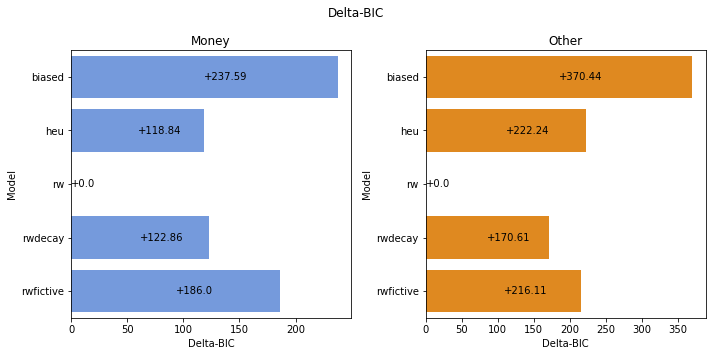

In [242]:
model_comparison(batch)